# **Bitcoin Analysis Using Time Series and Artificial Networks LSTM.**

#### **Descripción del problema.**

Se trata de predecir el precio del Bitcoin mediante el uso de modelos de series de tiempo y redes neuronales recurrentes de tipo LSTM.

In [0]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.set_option("display.float_format", lambda x: "%.4f" % x)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### **Parámetros del notebook.**

In [0]:
DATASET            = "https://raw.githubusercontent.com/ejdecena/TS-LSTM-Bitcoin-Analysis/master/BTC-USD.csv"
DAYS               = 3
USE_COLS           = ["Date", "Close", "Volume"]
SIGNIFICANCE_LEVEL = 0.05
DAYS_PREDICT       = 4
TRAIN_SIZE         = 0.80
RANDOM_SEED        = 27

np.random.seed(RANDOM_SEED)

#### **Carga de los datos del dataset.**

In [3]:
data         = pd.read_csv(DATASET, usecols=USE_COLS)
data["Date"] = pd.to_datetime(data["Date"])
print(data.head())
print("\nRows: {}. Columns: {}.".format(*data.shape))

        Date    Close    Volume
0 2016-05-22 439.3230  39657600
1 2016-05-23 444.1550  50582500
2 2016-05-24 445.9810  65783100
3 2016-05-25 449.5990  65231000
4 2016-05-26 453.3840  65203800

Rows: 1462. Columns: 3.


#### **Revisión de los datos.**

In [4]:
print("Null Values:")
print("------------\n")
data.isnull().sum()
print("\n\nData Info:")
print("----------\n")
data.info()

Null Values:
------------



Date      0
Close     0
Volume    0
dtype: int64



Data Info:
----------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1462 non-null   datetime64[ns]
 1   Close   1462 non-null   float64       
 2   Volume  1462 non-null   int64         
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 34.4 KB


#### **Visualización de los datos.**

In [0]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

<Figure size 576x576 with 0 Axes>

Text(0, 0.5, 'Price')

Text(0, 0.5, 'Volume')

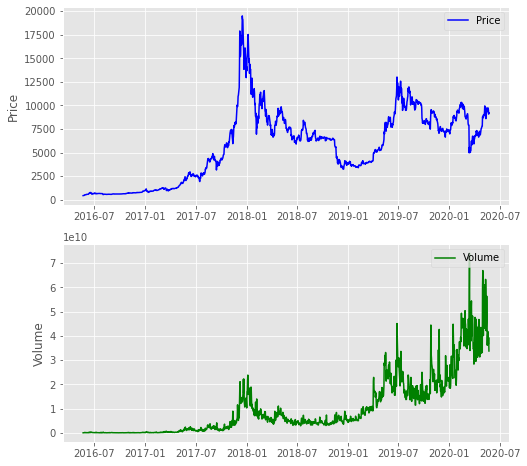

In [6]:
plt.figure(figsize=(8, 8))

plt.subplot(2, 1, 1)
plt.plot(data["Date"], data["Close"], color="b", label="Price")
plt.ylabel('Price')
plt.legend(loc="upper right")

plt.subplot(2, 1, 2)
plt.plot(data["Date"], data["Volume"], color="g", label="Volume")
plt.ylabel('Volume')
plt.legend(loc="upper right")

plt.show()

<Figure size 576x360 with 0 Axes>

(array([286.,  65.,  30.,  59.,  40., 127.,  35.,  37.,  37., 147., 101.,
         85.,  94.,  84.,  68.,  58.,  31.,  26.,   8.,   4.,   3.,   8.,
          6.,   5.,   3.,   6.,   3.,   3.,   0.,   3.]),
 array([  439.322998  ,  1074.59224443,  1709.86149087,  2345.1307373 ,
         2980.39998373,  3615.66923017,  4250.9384766 ,  4886.20772303,
         5521.47696947,  6156.7462159 ,  6792.01546233,  7427.28470877,
         8062.5539552 ,  8697.82320163,  9333.09244807,  9968.3616945 ,
        10603.63094093, 11238.90018737, 11874.1694338 , 12509.43868023,
        13144.70792667, 13779.9771731 , 14415.24641953, 15050.51566597,
        15685.7849124 , 16321.05415883, 16956.32340527, 17591.5926517 ,
        18226.86189813, 18862.13114457, 19497.400391  ]),
 <a list of 30 Patch objects>)

Text(0.5, 1.0, 'Frequency Histogram')

Text(0, 0.5, 'Frequency')

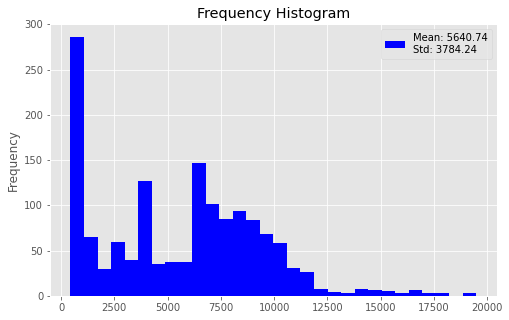

In [7]:
plt.figure(figsize=(8, 5))
label = "Mean: {:.2f}\nStd: {:.2f}".format(data["Close"].mean(), data["Close"].std())
plt.hist(data["Close"], color="b", label=label, bins=30)
plt.title("Frequency Histogram")
plt.ylabel('Frequency')
plt.legend(loc="upper right")
plt.show()

#### **Dickey-Fuller Stationarity Test.**

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.

* **Null Hypothesis (H0)**: If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
* **Alternate Hypothesis (H1)**: The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the *p-value* from the test. A *p-value* below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

* **p-value > 0.05**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
* **p-value <= 0.05**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data["Close"].values)
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
	print('\t%{}: {:.4f}'.format(key, value))
 
if result[1] > SIGNIFICANCE_LEVEL:
  print("\nThe data is non-stationary.")
else:
  print("\nThe data is stationary.")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


ADF Statistic: -2.1696657674716597
p-value: 0.21743862103668898
Critical Values:
	%1%: -3.4349
	%5%: -2.8635
	%10%: -2.5678

The data is non-stationary.


#### **RSI calculation and data scaling.**

In [9]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
price  = data["Close"].values.reshape(-1, 1)
price  = scaler.fit_transform(price)

data["U"]   = 0
data["D"]   = 0
data["t+1"] = np.nan

data.loc[0, "U"] = np.nan
data.loc[0, "D"] = np.nan

for i in range(1, len(data)):
    gap = data.loc[i, "Close"] - data.loc[i-1, "Close"]
    if gap > 0:
        data.loc[i, "U"]  = gap
        if i >= DAYS:
            data.loc[i,"t+1"] = 1  # If the price went up.
    else:
        data.loc[i, "D"]  = -gap
        if i >= DAYS:
            data.loc[i,"t+1"] = -1 # If the price went down.

data["MA_U"] = data["U"].rolling(window=DAYS).mean()
data["MA_D"] = data["D"].rolling(window=DAYS).mean()
data["RSI"]  = 100*(data["MA_U"]/(data["MA_U"] + data["MA_D"]))

data["Clo_Scaled"]= scaler.fit_transform(data[["Close"]])
data["Vol_Scaled"]= scaler.fit_transform(data[["Volume"]])
data["RSI_Scaled"]= scaler.fit_transform(data[["RSI"]])

added = ["Clo_Scaled","Vol_Scaled", "U", "D", "MA_U", "MA_D", "RSI", "RSI_Scaled", "t+1"]
USE_COLS.extend(added)
data = data[USE_COLS]
print("FINAL DATASET:")
data.head()
print("Rows: {}. Columns: {}.".format(*data.shape))

FINAL DATASET:


,Date,Close,Volume,Clo_Scaled,Vol_Scaled,U,D,MA_U,MA_D,RSI,RSI_Scaled,t+1
0,2016-05-22,439.3230,39657600,0.0000,0.0001,nan,nan,nan,nan,nan,nan,nan
1,2016-05-23,444.1550,50582500,0.0003,0.0002,4.8320,0.0000,nan,nan,nan,nan,nan
2,2016-05-24,445.9810,65783100,0.0003,0.0004,1.8260,0.0000,nan,nan,nan,nan,nan
3,2016-05-25,449.5990,65231000,0.0005,0.0004,3.6180,0.0000,3.4253,0.0000,100.0000,1.0000,1.0000
4,2016-05-26,453.3840,65203800,0.0007,0.0004,3.7850,0.0000,3.0763,0.0000,100.0000,1.0000,1.0000


Rows: 1462. Columns: 12.


#### **Preprocesado de los datos y división del dataset.**

In [10]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = preprocess(price, SEQ_LEN, train_split=TRAIN_SIZE)
print("X Train:", X_train.shape, "X Test:", X_test.shape)

X Train: (1089, 99, 1) X Test: (273, 99, 1)


In [0]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM

In [12]:
DROPOUT     = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()

model.add(Bidirectional(LSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))
model.add(Dense(units=1))

model.add(Activation('linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 99, 198)           79992     
_________________________________________________________________
dropout (Dropout)            (None, 99, 198)           0         
_________________________________________________________________
dense (Dense)                (None, 99, 1)             199       
_________________________________________________________________
activation (Activation)      (None, 99, 1)             0         
Total params: 80,191
Trainable params: 80,191
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='mean_squared_error', optimizer='adam')
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=50, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

Epoch 1/50
16/16 [==============================] - 3s 213ms/step - loss: 0.0244 - val_loss: 0.0259
Epoch 2/50
16/16 [==============================] - 3s 160ms/step - loss: 0.0210 - val_loss: 0.0299
Epoch 3/50
16/16 [==============================] - 3s 159ms/step - loss: 0.0171 - val_loss: 0.0369
Epoch 4/50
16/16 [==============================] - 3s 158ms/step - loss: 0.0177 - val_loss: 0.0311
Epoch 5/50
16/16 [==============================] - 3s 158ms/step - loss: 0.0165 - val_loss: 0.0329
Epoch 6/50
16/16 [==============================] - 3s 157ms/step - loss: 0.0169 - val_loss: 0.0312
Epoch 7/50
16/16 [==============================] - 3s 158ms/step - loss: 0.0163 - val_loss: 0.0316
Epoch 8/50
16/16 [==============================] - 3s 160ms/step - loss: 0.0164 - val_loss: 0.0308
Epoch 9/50
16/16 [==============================] - 3s 159ms/step - loss: 0.0162 - val_loss: 0.0309
Epoch 10/50
16/16 [==============================] - 3s 160ms/step - loss: 0.0162 - val_loss: 0.0302

In [14]:
model.evaluate(X_test, y_test)

9/9 [==============================] - 0s 25ms/step - loss: 0.0058


0.005795020144432783

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Model Loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

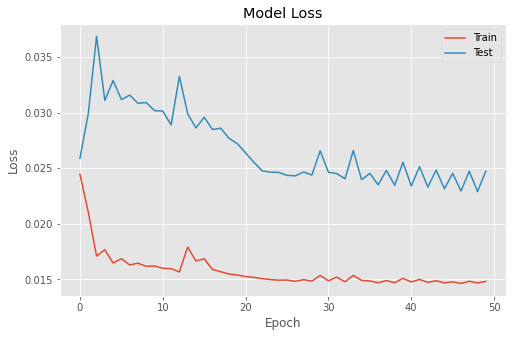

In [15]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

<Figure size 576x360 with 0 Axes>

Text(0.5, 1.0, 'Bitcoin Price Prediction')

Text(0.5, 0, 'Time [days]')

Text(0, 0.5, 'Price')

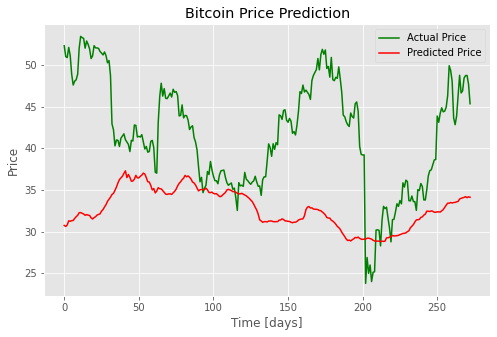

In [16]:
y_hat = model.predict(X_test)

y_test_inverse = scaler.inverse_transform(y_test)
y_hat_inverse = scaler.inverse_transform(y_hat[:,0])

plt.figure(figsize=(8, 5))
plt.plot(y_test_inverse, label="Actual Price", color='green')
plt.plot(y_hat_inverse, label="Predicted Price", color='red')
 
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='upper right')
 
plt.show()